# **ARIMA-Based Time Series Forecasting Simulator**

### **Step 1: Install Required Libraries**

In [1]:
# Install dependencies
!pip install statsmodels pandas numpy matplotlib scikit-learn pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 487.8 kB/s eta 0:00:00a 0:00:01


### **Step 2: Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from pmdarima import auto_arima

### **Step 3: Generate Simulated Sensor Data**

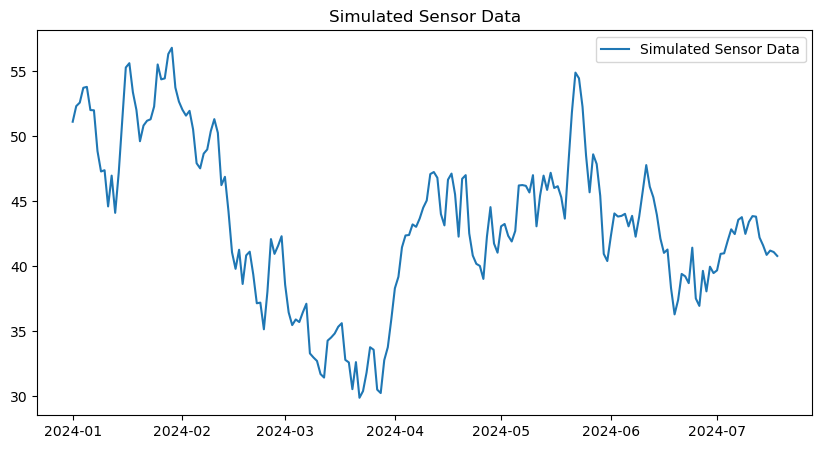

In [3]:
# Generate time-series data
date_rng = pd.date_range(start='2024-01-01', periods=200, freq='D')
sensor_values = np.cumsum(np.random.randn(200) * 2) + 50  # Simulated sensor readings

# Create DataFrame
df = pd.DataFrame({'timestamp': date_rng, 'sensor_value': sensor_values})
df.set_index('timestamp', inplace=True)

# Plot data
plt.figure(figsize=(10,5))
plt.plot(df, label="Simulated Sensor Data")
plt.title("Simulated Sensor Data")
plt.legend()
plt.show()

### **Step 4: Check for Stationarity**

In [4]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] > 0.05:
        print("The data is non-stationary. Differencing needed.")
    else:
        print("The data is stationary.")

check_stationarity(df['sensor_value'])

ADF Statistic: -2.4332883091038235
p-value: 0.13256056659240434
The data is non-stationary. Differencing needed.


### **Step 5: Determine Optimal ARIMA Parameters**

In [5]:
# Automatically determine the best ARIMA parameters
auto_arima_model = auto_arima(df['sensor_value'], seasonal=False, trace=True, suppress_warnings=True)
p, d, q = auto_arima_model.order
print(f"Optimal ARIMA Order: ({p}, {d}, {q})")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=820.046, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=819.079, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=818.865, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=818.257, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=817.231, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=819.122, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.107 seconds
Optimal ARIMA Order: (0, 1, 0)


### **Step 6: Train ARIMA Model**

In [6]:
# Fit ARIMA model
model = ARIMA(df['sensor_value'], order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           sensor_value   No. Observations:                  200
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -407.616
Date:                Tue, 11 Feb 2025   AIC                            817.231
Time:                        10:47:08   BIC                            820.524
Sample:                    01-01-2024   HQIC                           818.564
                         - 07-18-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.5211      0.374      9.425      0.000       2.789       4.253
Ljung-Box (L1) (Q):                   2.24   Jarque-Bera (JB):                 0.39
Prob(Q):                              0.13   Pr

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### **Step 7: Forecast Future Sensor Values**

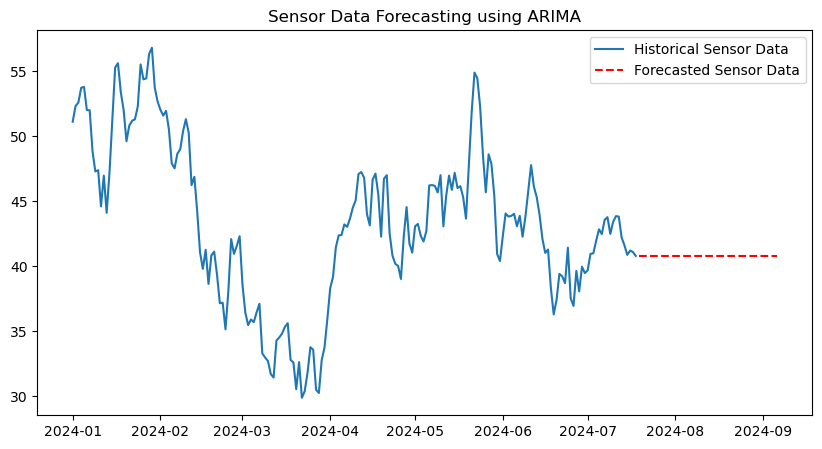

In [7]:
# Forecast next 50 time steps
future_steps = 50
forecast = model_fit.forecast(steps=future_steps)

# Generate future dates
future_dates = pd.date_range(start=df.index[-1], periods=future_steps+1, freq='D')[1:]

# Create forecast DataFrame
forecast_df = pd.DataFrame({'timestamp': future_dates, 'forecasted_value': forecast})
forecast_df.set_index('timestamp', inplace=True)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(df, label="Historical Sensor Data")
plt.plot(forecast_df, label="Forecasted Sensor Data", linestyle='dashed', color='red')
plt.title("Sensor Data Forecasting using ARIMA")
plt.legend()
plt.show()

### **Step 8: Evaluate Forecast Performance**

In [8]:
# Evaluate model performance (for last 50 known values)
y_test = df['sensor_value'].iloc[-50:]
y_pred = model_fit.predict(start=len(df)-50, end=len(df)-1)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 1.1839420566721492
